In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from classification import Classification

In [1]:
data = pd.read_csv('../Miscellaneous/Data/Plumguide/leads_conversion.csv')
data.head(2)

NameError: name 'pd' is not defined

# 1. Exploratory Data Analysis

In [3]:
data.shape

(2662, 5)

In [4]:
# check for any missing values and types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_distinct_views  2662 non-null   int64  
 1   device_type         2662 non-null   object 
 2   platform            2662 non-null   object 
 3   value_gbp           2662 non-null   float64
 4   converted           2662 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 85.9+ KB


In [5]:
# an initial look at the distribution of the numerical columns
data.describe()

,num_distinct_views,value_gbp
count,2662.000000,2662.000000
mean,9.649887,4270.494582
std,15.182142,7854.178870
min,1.000000,0.000000
25%,2.000000,997.000000
50%,5.000000,2000.000000
75%,11.000000,4000.000000
max,193.000000,96145.000000


### Lets look at the balance of classes of the converted column

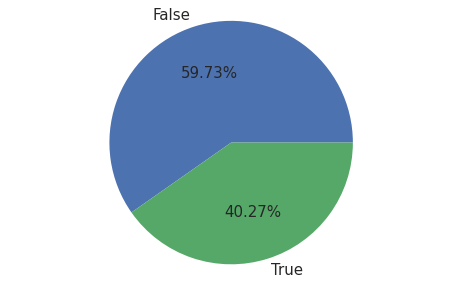

In [6]:
# distribution of the 'converted' column to see the balance of the classes
data.groupby('converted').size().plot.pie(figsize=(8, 5), fontsize=15, autopct='%.2f%%')
plt.axis('equal')
plt.ylabel("")
plt.show()

### Lets look at the categorical columns and explore their relationship with the converted column. 

In [7]:
# list of names of categorical columns
cat_columns = ['device_type', 'platform']

In [8]:
# function to create pivot table with count of rows for each category in a category column, split by converted
def column_pivotable(column, df):
    return data.pivot_table(values='num_distinct_views', index=column, columns='converted', aggfunc='count')\
            .sort_values(by=False, ascending=False)

# function to calculate percentage of converted column for each category in each categorical column
def get_converted_proportion(column, df):
    temp_df = data.groupby([column, 'converted',]).size().sort_values(ascending=False)
    temp_df_index = list(temp_df.reset_index().iloc[:,0].values)
    return temp_df.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2)).unstack() \
    .reindex([i for n,i in enumerate(temp_df_index) if i not in temp_df_index[:n]]) 

def plot_params(column):   
    plt.ylabel(column, fontsize=18) 
    plt.xlabel('')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12, rotation=45)
    plt.legend(bbox_to_anchor=(1.15, 1), fontsize=13)

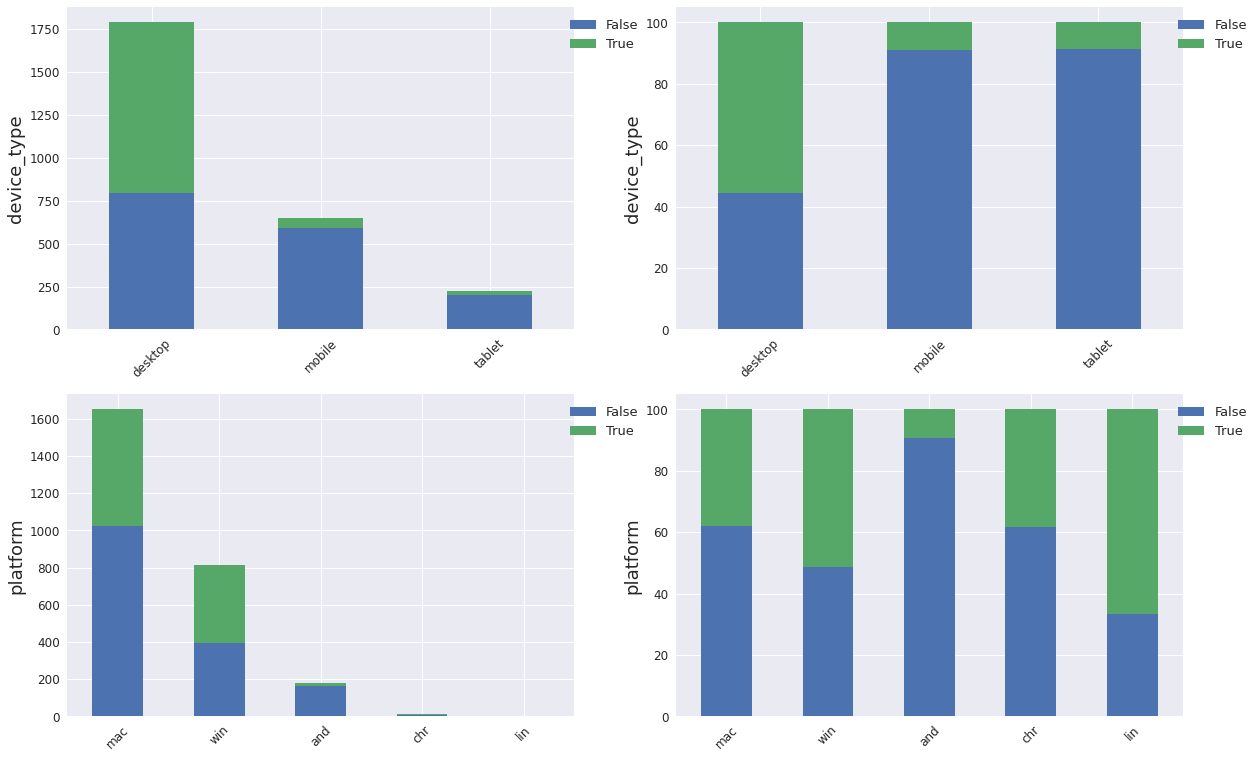

In [9]:
fig = plt.figure(figsize=(20, 70))
for i, column in enumerate(cat_columns):
    axs = fig.add_subplot(10, 2, (i*2)+1)
    column_pivotable(column, data).plot.bar(stacked=True, ax=axs)
    plot_params(column)
    axs = fig.add_subplot(10, 2, (i*2)+2)
    get_converted_proportion(column, data).plot.bar(stacked=True, ax=axs)
    plot_params(column)
plt.show()

### Lets look at the numerical columns and explore their relationship with the converted column. 

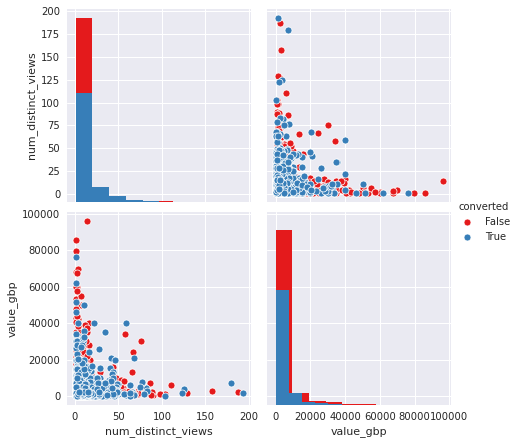

In [10]:
# scatter plots to explore the relationship among the numerical columns and histograms
sns.pairplot(data, diag_kind='hist',  hue= 'converted', height=3, palette="Set1")
plt.show()

In [11]:
# Lets look at the percentage of rows with num_distinct_views > 100 
len(data[data['num_distinct_views'] > 100])/len(data) * 100

0.4132231404958678

In [12]:
# Lets look at the percentage of rows with value_gbp>20,000 
len(data[data['value_gbp'] > 20000])/len(data)*100

3.5311795642374153

In [13]:
# check correlations among the numerical columns
round(data.loc[:, ['num_distinct_views', 'value_gbp']].corr(method='pearson'), 3)

,num_distinct_views,value_gbp
num_distinct_views,1.000,-0.003
value_gbp,-0.003,1.000


## 2. Preprocessing

In [3]:
# Lets first encode the taget variable
label_encoder = LabelEncoder()
data_new = data.copy()
data_new['converted'] = label_encoder.fit_transform(data_new['converted'])

# One hot code the categorical variables and drop the first columns
data_new = pd.get_dummies(data_new, drop_first=True)

In [4]:
# Lets split the data in training and test sets with stratification to keep the proportion of target classes even
stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_index, test_index in stratifier.split(data_new, data_new['converted']):
    train_data = data_new.loc[train_index]
    test_data = data_new.loc[test_index]

In [5]:
# Lets now further split the train and test sets to features and labels
xtrain = train_data.drop('converted', axis=1)
ytrain = train_data['converted']
xtest = test_data.drop('converted', axis=1)
ytest = test_data['converted']

## 3. Baseline Model

For this project I'll be using the following classifiers:
1. Gaussian Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

In [6]:
# Create a dictionary of the classifiers
classifiers = {}
classifiers['GNB'] = GaussianNB()
classifiers['LR'] = LogisticRegression(random_state=10)
classifiers['RF'] = RandomForestClassifier(random_state=10)
classifiers['XGB'] = XGBClassifier(random_state=10)

# Create a dictionary with the parameters to train for the classifiers
parameters = {}
parameters['GNB'] = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
parameters['LR'] = {'classifier__penalty' : ['l1', 'l2'],
                    'classifier__solver': ['lbfgs', 'liblinear']}
parameters['RF'] = {'classifier__n_estimators': list(range(50, 450, 50))}
parameters['XGB'] = {'classifier__booster': ['gbtree', 'gblinear']}

In [7]:
# initialise the data
base_data = Classification( xtrain, ytrain, xtest, ytest)

# grid search for the best classifiers
base_result = base_data.grid_search(classifiers, parameters)

In [8]:
# result comparison based on accuracy
base_data.model_comparison()

,model,train_accuracy,crossVal_mean_accuracy,test_accuracy,refit_time
0,GNB,0.672,0.657,0.694,0.012
1,LR,0.712,0.713,0.715,0.012
2,RF,0.940,0.683,0.677,0.253
3,XGB,0.712,0.712,0.717,0.032


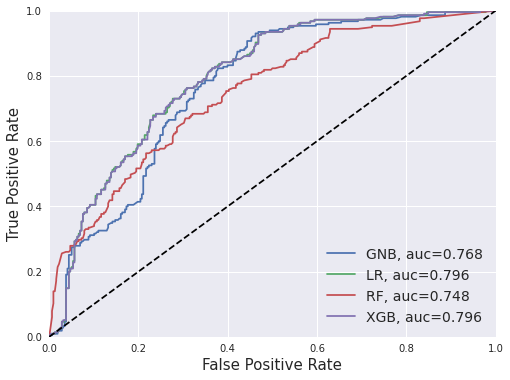

In [9]:
# result comparison based on ROC-AUC
base_data.plot_rocs()

In [10]:
print(confusion_matrix(ytest, base_result['GNB']['model'].best_estimator_.predict(xtest)))
print(classification_report(ytest, base_result['GNB']['model'].best_estimator_.predict(xtest)))

[[175 143]
 [ 20 195]]
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       318
           1       0.58      0.91      0.71       215

    accuracy                           0.69       533
   macro avg       0.74      0.73      0.69       533
weighted avg       0.77      0.69      0.69       533



In [11]:
print(confusion_matrix(ytest, base_result['LR']['model'].best_estimator_.predict(xtest)))
print(classification_report(ytest, base_result['LR']['model'].best_estimator_.predict(xtest)))

[[217 101]
 [ 51 164]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       318
           1       0.62      0.76      0.68       215

    accuracy                           0.71       533
   macro avg       0.71      0.72      0.71       533
weighted avg       0.73      0.71      0.72       533



In [28]:
def best_threshold(model, xtest=xtest, ytest=ytest):
    y_probs = model.predict_proba(xtest)[:, 1]
    thresholds = np.arange(0, 1, 0.001)
    f1_scores = [f1_score(ytest, (y_probs>=threshold).astype('int')) for threshold in thresholds] 
    accuracies = [accuracy_score(ytest, (y_probs>=threshold).astype('int')) for threshold in thresholds]
    ix = np.argmax(f1_scores)
    return thresholds[ix],  round(f1_scores[ix], 3), round(accuracies[ix], 3)

In [29]:
# based on accuracy
for k, v in base_result.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_)}")

GNB: (0.632, 0.68, 0.705)
LR: (0.527, 0.671, 0.73)
RF: (0.554, 0.598, 0.694)
XGB: (0.528, 0.668, 0.728)


In [14]:
# based on f1_score
for k, v in base_result.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_)}")

GNB: (0.234, 0.712, 0.696)
LR: (0.442, 0.707, 0.69)
RF: (0.073, 0.657, 0.602)
XGB: (0.439, 0.707, 0.69)


## 4. Resampling

### Upsampling

In [15]:
# oversampling
os_data = Classification( xtrain, ytrain, xtest, ytest)
os_data.resample('over')

# let's look at the class distribution of the train set after sampling
os_data.ytrain.value_counts()

1    1272
0    1272
Name: converted, dtype: int64

In [16]:
os_result = os_data.grid_search(classifiers, parameters)

In [17]:
os_data.model_comparison()

,model,train_accuracy,crossVal_mean_accuracy,test_accuracy,refit_time
0,GNB,0.713,0.671,0.694,0.004
1,LR,0.713,0.711,0.685,0.011
2,RF,0.941,0.757,0.660,0.790
3,XGB,0.881,0.738,0.681,0.089


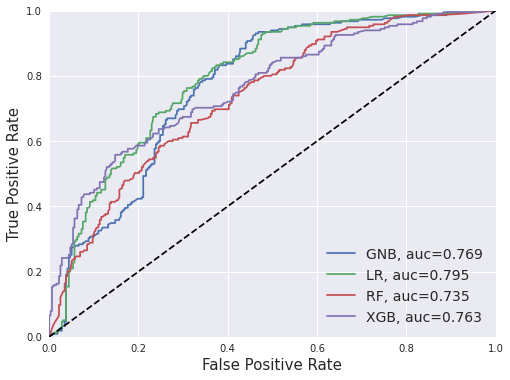

In [18]:
os_data.plot_rocs()

In [19]:
print(confusion_matrix(ytest, os_result['LR']['model'].best_estimator_.predict(xtest)))
print(classification_report(ytest, os_result['LR']['model'].best_estimator_.predict(xtest)))

[[164 154]
 [ 14 201]]
              precision    recall  f1-score   support

           0       0.92      0.52      0.66       318
           1       0.57      0.93      0.71       215

    accuracy                           0.68       533
   macro avg       0.74      0.73      0.68       533
weighted avg       0.78      0.68      0.68       533



In [20]:
for k, v in os_result.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_)}")

GNB: (0.467, 0.712, 0.696)
LR: (0.527, 0.705, 0.687)
RF: (0.07200000000000001, 0.652, 0.597)
XGB: (0.231, 0.652, 0.632)


### Smote Tomek

In [21]:
# smote tomek
smt_data = Classification(xtrain, ytrain, xtest, ytest)
smt_data.resample('smote')

# let's look at the class distribution of the train set after sampling
smt_data.ytrain.value_counts()

1    1097
0    1097
Name: converted, dtype: int64

In [22]:
smt_result = smt_data.grid_search(classifiers, parameters)

In [23]:
smt_data.model_comparison()

,model,train_accuracy,crossVal_mean_accuracy,test_accuracy,refit_time
0,GNB,0.721,0.676,0.692,0.005
1,LR,0.752,0.736,0.702,0.011
2,RF,0.934,0.749,0.668,0.380
3,XGB,0.890,0.756,0.679,0.078


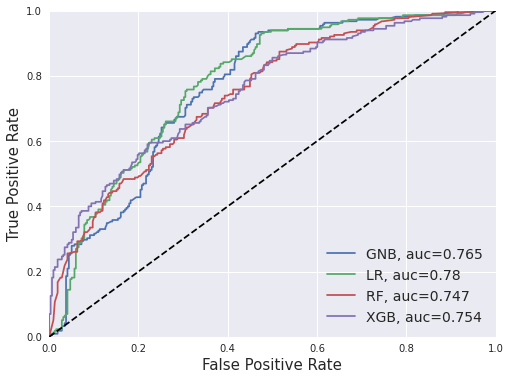

In [24]:
smt_data.plot_rocs()

In [25]:
print(confusion_matrix(ytest, smt_result['LR']['model'].best_estimator_.predict(xtest)))
print(classification_report(ytest, smt_result['LR']['model'].best_estimator_.predict(xtest)))

[[196 122]
 [ 37 178]]
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       318
           1       0.59      0.83      0.69       215

    accuracy                           0.70       533
   macro avg       0.72      0.72      0.70       533
weighted avg       0.74      0.70      0.70       533



In [26]:
for k, v in smt_result.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_)}")

GNB: (0.248, 0.712, 0.696)
LR: (0.41000000000000003, 0.707, 0.687)
RF: (0.131, 0.661, 0.629)
XGB: (0.17500000000000002, 0.659, 0.644)


## 5. Model selection

In [27]:
base_result['LR']['model'].best_params_

{'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}